In [296]:
# Imports for Grady's NN Files
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

# My Imports
import csv
import time
import random
from numpy.linalg import norm
from numpy import (array, dot, arccos, clip)
from matplotlib.ticker import FormatStrFormatter

from sklearn import neural_network

__Note:__ We're interested in the algorithms' ability to follow an "optimal" (for now random) path, so we don't need to generate them in _real time_. Which makes it ok to pre-compute the waypoints as opposed to generate them on the fly.

## Path Generation Based on Existing Waypoints

In [203]:
# Getting existing waypoints
fileName = 'Waypoints.txt'
def getWaypoints(fileName):
    f = open(fileName, 'r')
    r = csv.reader(f, delimiter=',')
    xy = [row for row in r]
    x = [float(row[0]) for row in xy]
    y = [float(row[1]) for row in xy]
    f.close()
    return x, y 

# Generating new randomized waypoints from file
def generateWaypoints(fileName, var):
    x, y = getWaypoints(fileName)
    xnew = [(i + random.uniform(-var, var)) for i in x]
    ynew = [(i + random.uniform(-var, var)) for i in y]
    return xnew, ynew

# Generating new randomized waypoints given points
def generateWaypoints2(x, y, var):
    xnew = [(i + random.uniform(-var, var)) for i in x]
    ynew = [(i + random.uniform(-var, var)) for i in y]
    return xnew, ynew

In [190]:
waypoints = 'Waypoints.txt'
x_waypoints, y_waypoints = getWaypoints(waypoints)
xrand1, yrand1 = generateWaypoints(waypoints, 0.5)
xrand2, yrand2 = generateWaypoints(waypoints, 1.0)
xrand3, yrand3 = generateWaypoints(waypoints, 1.5)

# Plotting (COMMENTED OUT FOR NOW, tryng simpler paths)
#f1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 5), sharex='col', sharey='row')
#f1.suptitle(r'Original vs. Randomized waypoints (with variance $\sigma = 0.5, 1.0, 1.5$)')
#ax1.plot(x_waypoints, y_waypoints)
#ax2.plot(xrand1, yrand1)
#ax3.plot(xrand2, yrand2)
#ax4.plot(xrand3, yrand3)

# PROBLEM: Doing it this way, you sometimes get waypoints that go backwards if the variance is too high!
# SOLUTION? I could try to find a line perpendicular to the track at each point and generate the randomized point along that...

(-5, 5)

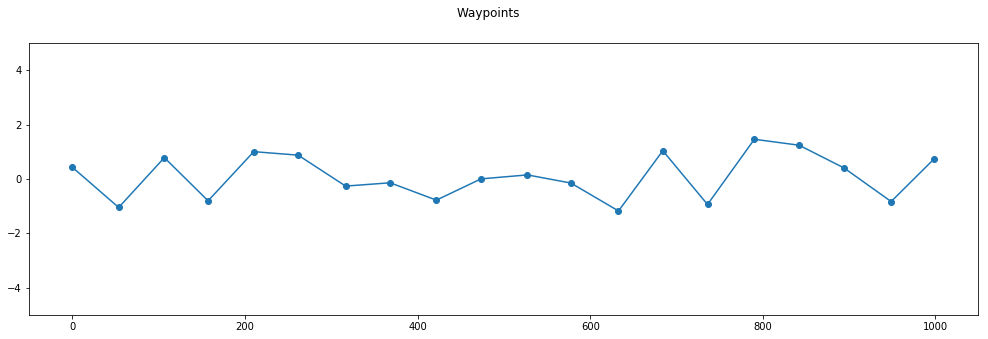

In [420]:
variance = 1.5

x_evenly_spaced = np.linspace(0, 1000, 20)
y_evenly_spaced = np.linspace(0, 0, 20)
x_waypoints, y_waypoints = generateWaypoints2(x_evenly_spaced, y_evenly_spaced, variance)

f1, ((ax1)) = plt.subplots(1, 1, figsize=(17, 5), sharex='col', sharey='row')
ax1.plot(x_waypoints, y_waypoints, 'o-')
f1.suptitle(r'Waypoints')
ax1.set_ylim([-5, 5])

## Throttle PID Controller (2D Cartesian)
__Note:__ May need to implement smoothing depending on how well this runs

In [346]:
throttleInput, lastError = throttlePID(0, 0, -3, 0, False, 0, 0.1)
throttleInput

3.0


0.18059999999999998

In [419]:
# INPUTS: Current x position, current y position, desired x position, desired y position, whether we just passed a point,
#         time difference since last point
# OUTPUTS: The THROTTLE value to apply, the position error (for future D calculations)
def throttlePID(velocityTarget, xdesired, ydesired, changingPoint, lastError, ITerm, dtime):
    # 0. Defining random gains
    kp = 0.01
    ki = 0.0002
    kd = 0.005
    ITermMin = -1
    ITermMax = 1
    
    # 1. Find error based on absolute distance between current position and desired position
    currentVelocity = 
    velocityError = 
    # 
    
    # 3. Obtain P, I, and D values:
    ## P
    PTerm = kp * positionError
    
    ## I
    if(changingPoint):                # Not sure this is actually the correct way to handle the constant positive I problem
        ITerm = 0
    ITerm += ki * positionError
    if (ITerm > ITermMax):
        ITerm = ITermMax
    elif (ITerm < ITermMin):
        ITerm = ITermMin;
    
    #D
    dposition = (positionError - lastError) / dtime
    DTerm = kd * dposition;
    
    sumPID = PTerm + ITerm + DTerm
    return (sumPID, positionError)

Text(0.5,0.98,'Throttle inputs across waypoints')

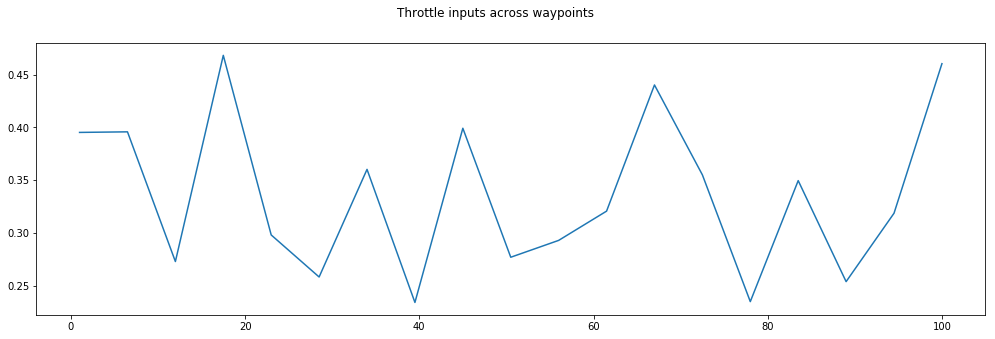

In [418]:
# Testing Throttle PID: Creating an array of all the PID values that would be output if the car was exactly at every point
#                       (not in between) and wanted to reach the exact next point. Also assigns the past error as 0 and the 
#                       difference in time since last calculation 0.1,
# NOTE: This just shows that the throttlePID function correctly outputs different PID values 
throttleAtPoints = []
for i, j in zip(range(0, len(x_waypoints) - 1), range(0, len(y_waypoints)-1)):
    sumPID, pastError = throttlePID(x_waypoints[i], y_waypoints[j], x_waypoints[i + 1], y_waypoints[j + 1], True, 0, 0.1)
    throttleAtPoints.append(sumPID)

f2, ((ax2)) = plt.subplots(1, 1, figsize=(17, 5), sharex='col', sharey='row')
ax2.plot(np.linspace(1, 100,len(throttleAtPoints)), throttleAtPoints)
f2.suptitle(r'Throttle inputs across waypoints')
#ax2.set_ylim([0, 1])

## Steering PID Controller

In [301]:
u = (0, 1)
v = (1, 0)
c = dot(u, v) / (norm(u) * norm(v))
angle = arccos(clip(c, -1, 1))
angle

1.5707963267948966

In [313]:
# INPUTS: Current x position, current y position, desired x position, desired y position, whether we just passed a point,
#         time difference since last point
# OUTPUTS: The STEERING value to apply, the angular error (for future D calculations)
def steeringPID(x_current, y_current, x_target, y_target, changingPoint, lastError, dtime, headingCurrent):
    # 0. Defining random gains
    kp = 0.01
    ki = 0.0002
    kd = 0.005
    ITermMin = -2
    ITermMax = 2
    ITerm = 0
    
    # 2. Find error based on angle between current heading direction and direction to target point
    u = (x_target - x_current, y_target - y_current)
    v = (1, 0)
    c = dot(u, v) / (norm(u) * norm(v))
    heading_target = arccos(clip(c, -1, 1))
    angularError = heading_target - headingCurrent
    
    # 3. Obtain P, I, and D values:
    ## P
    PTerm = kp * angularError
    
    ## I
    if(changingPoint):                # Not sure this is actually the correct way to handle the constant positive I problem
        ITerm = ITermMin
    ITerm += ki * angularError
    if (ITerm > ITermMax):
        ITerm = ITermMax
    elif (ITerm < ITermMin):
        ITerm = ITermMin;
    
    #D
    dposition = (angularError - lastError) / dtime
    DTerm = kd * dposition;
    
    sumPID = PTerm + ITerm + DTerm
    return (sumPID, angularError)

(-0.1, 0.1)

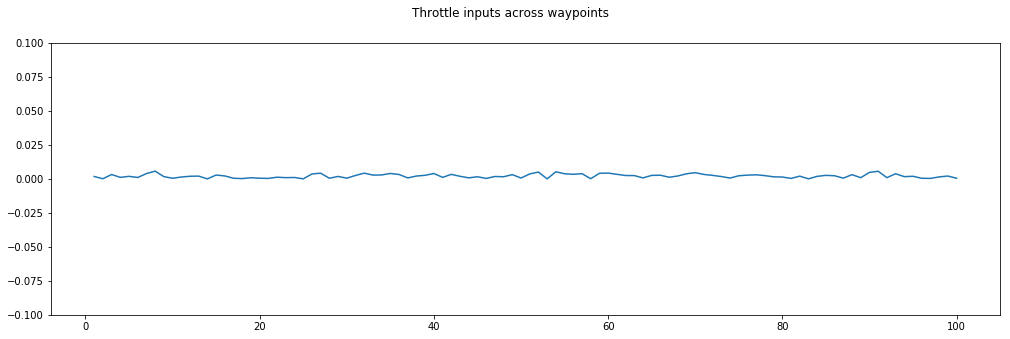

In [314]:
# Testing Steering PID: Same as for throttle PID
steeringAtPoints = []
for i, j in zip(range(0, len(x_waypoints) - 1), range(0, len(y_waypoints)-1)):
    sumPID, pastError = steeringPID(x_waypoints[i], y_waypoints[j], x_waypoints[i + 1], y_waypoints[j + 1], True, 0, 0.1, 0)
    steeringAtPoints.append(sumPID)

f3, ((ax3)) = plt.subplots(1, 1, figsize=(17, 5), sharex='col', sharey='row')
ax3.plot(np.linspace(1, 100,len(steeringAtPoints)), steeringAtPoints)
f3.suptitle(r'Throttle inputs across waypoints')
ax3.set_ylim([-0.1, 0.1])

## Neural Network State Estimator (Grady's stuff)

In [8]:
# Check if you can input weights for scikit learns MLPRegressor to use the stuff Grady sent.

In [141]:
class AutoRallyNet:

    def __init__(self, save_path, dt = 0.02):
        self.weight_dict = np.load(save_path)
        self.non_linearity = np.tanh
        self.dt = dt
    
    def __call__(self, x, steering, throttle):
        state = np.copy(x) #Don't modify x, return updated state as new variable
        #First compute the state derivative
        fn_input = np.concatenate([state[3:], [steering], [throttle]])
        h1 = np.dot(self.weight_dict["dynamics_W1"], fn_input) + self.weight_dict["dynamics_b1"]
        h1 = np.tanh(h1)
        h2 = np.dot(self.weight_dict["dynamics_W2"], h1) + self.weight_dict["dynamics_b2"]
        h2 = np.tanh(h2)
        state_der = np.dot(self.weight_dict["dynamics_W3"], h2) + self.weight_dict["dynamics_b3"]
        #Now compute the actual state update
        state[0] += (np.cos(state[2])*state[4] - np.sin(state[2])*state[5])*self.dt
        state[1] += (np.sin(state[2])*state[4] + np.cos(state[2])*state[5])*self.dt
        state[2] += -state[6]*self.dt #Sixth state is NEGATIVE of yaw derivative
        state[3] += state_der[0]*self.dt
        state[4] += state_der[1]*self.dt
        state[5] += state_der[2]*self.dt
        state[6] += state_der[3]*self.dt
        return state

In [142]:
def animate(npy_array, name):
    save_as = name + ".mp4"
    Xs = npy_array[:, 0]
    Ys = npy_array[:, 1]
    Yaw = npy_array[: ,2]
    Vx = npy_array[:, 4]
    Vy = npy_array[:, 4]*np.tan(npy_array[:, 3])
    T = range(Xs.size)
    fig = plt.figure()
    ax = plt.axes(xlim=(0,20), ylim = (-10,10))
    Xs = np.array(Xs)
    Ys = np.array(Ys)
    lines = []
    line, = ax.plot([],[])
    circs = []
    circs.append(Rectangle((Xs[0] - .30, Ys[0] - .13), .6, .26, color = 'r'))
    def init():
        line.set_data([], [])
        for c in circs:
            ax.add_patch(c)
        return circs,
    def animate(k):
        for c in circs:
            heading = Yaw[k]/np.pi * 180.0
            t = mpl.transforms.Affine2D().rotate_deg_around(Xs[k], Ys[k], heading) + ax.transData
            c.set_transform(t)
            c.set_xy((Xs[k] - .3, Ys[k] - .13))
        x = np.copy(Xs[:k])
        y = np.copy(Ys[:k])
        sys.stdout.write("Making Animation: %d/%d \r" % (k, len(Xs)))
        sys.stdout.flush()
        line.set_data(x,y)
        line.set_alpha(.1)
        return circs,
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames = len(Xs), interval=20,blit=True)
    anim.save(save_as, fps=50, writer='avconv', bitrate = 2500)

In [32]:
if __name__ == "__main__":
    steering = np.clip(np.random.randn(250), -1, 1)        # Generates values from the normal distribution clamped between [-1 1]
    throttle = np.clip(np.random.randn(250), -1, 0.75)
    x = np.array([0, 0, 0, 0, 5.0, 0.5, 0])
    state_history = []

    f = AutoRallyNet("alpha_nnet.npz")

    for i in range(250):
        state_history.append(x)
        x = f(x, steering[i], throttle[i])

    #animate(np.asarray(state_history), "random_controls")

## <center> MAIN CONTROLLER <center>

In [315]:
def runPID():
    TIME_RUNNING_SIMLUATION = 3
    
    # Definiing Initial State and Target
    x_start, y_start = x_waypoints[0], y_waypoints[0]
    x = np.array([x_waypoints[0], y_waypoints[0], 0, 0, 0, 0, 0])          # Initial state
    x_last = []                                                            # Last state
    state_history = []
    targetIndex = 1
    xTarget, yTarget = x_waypoints[targetIndex], y_waypoints[targetIndex]  # Starting target positions
    proxThreshold = 0.25                                                   # Proximity to a point within which we have "reached it"
    changingPoint = True                                                   # See note above
    
    throttle_history = []
    steering_history = []
    
    # PID values:
    lastThrottleError = 0
    lastSteeringError = 0
    velocityTarget = 0
    timeStep = 1
    dtime = 0.01
    
    # Start timer and loop
    keepGoing = True
    startTime = time.time()
    while(keepGoing):        
        # 1. Our current and target x and y are defined, if we're close enough to the desired, update target to next waypoint
        xCurr, yCurr = x[0], x[1]
        xLast, yLast = x_last[0], x_last[1]
        distanceToTarget = np.sqrt((xTarget - xCurr)**2 + (yTarget - yCurr)**2)
        if (distanceToTarget < proxThreshold):
            x_start, y_start = xTarget, yTarget
            targetIndex += 1
            xTarget, yTarget = x_waypoints[targetIndex], y_waypoints[targetIndex]
            changingPoint = True
        else:
            changingPoint = False
        
        # 2.a) Compute throttle PID
        distanceBetweenPoints = np.sqrt((xTarget - x_start)**2 + (yTarget - y_start)**2)
        velocityTarget = distanceBetweenPoints / timeStep   # target velocity = distance / time in which you want to cover it
        currentVelocity = 
        throttleInput, lastThrottleError = throttlePID(velocityTarget xTarget, yTarget, changingPoint, lastThrottleError, dtime)
        
        # 2.b) Compute steering PID
        steeringInput, lastSteeringError = steeringPID(xCurr, yCurr, xTarget, yTarget, changingPoint, lastSteeringError, dtime, x[3])
        
        # 3. Apply that PID and use the NN to estimate new position. PROBLEM: Do it time or space based? SOLUTION? Try time interval of 0.01s first (edge case is if we're not moving, handle that too)
        state_history.append(x)
        throttle_history.append(throttleInput)
        x = f(x, steeringInput, throttleInput)
        
        # 4. Stop running after however long/many laps you want
        currTime = time.time()
        if (currTime - startTime >= TIME_RUNNING_SIMLUATION):
            keepGoing = False
    
    return (state_history, throttle_history)

In [316]:
state_history, throttle_history = runPID()

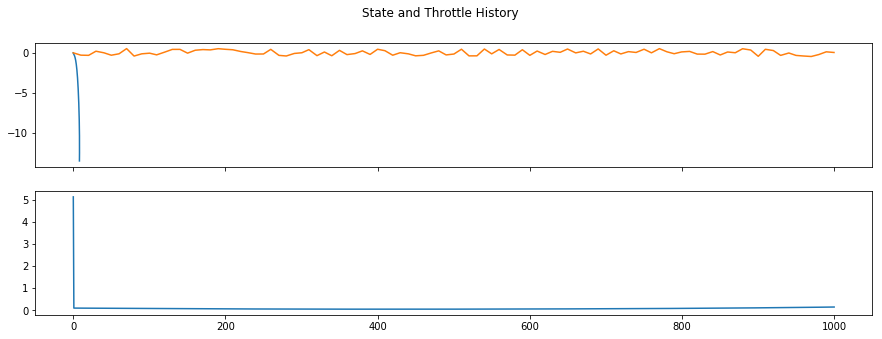

In [317]:
x_states = [row[0] for row in state_history]
y_states = [row[1] for row in state_history]
x_time = np.linspace(0, 1000, len(throttle_history))

f1, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(15, 5), sharex='col', sharey='row')
f1.suptitle(r'State and Throttle History')
ax1.plot(x_states, y_states, x_waypoints, y_waypoints)
ax2.plot(x_time, throttle_history)